In [1]:
import pandas as pd
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')
df = df.drop(columns=['Ref#','Heat treatment','Other RM/Rivet/part cost (€/Part)','Gross Weight (g)','Other assembled RM/Rivet/part','Heat Treatment cost (€/Part)'])
df['Raw Material'] = df['Raw Material'].str.title()
df = df.fillna('0')


# Catboost

### 1. Target: Log + Hyperparameter: Search

[I 2025-05-15 10:07:43,294] A new study created in memory with name: no-name-6e160bfd-256d-4009-b431-5f54a563cfe0


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-15 10:08:50,348] Trial 0 finished with value: 0.20341193826195175 and parameters: {'depth': 5, 'learning_rate': 0.07969454818643935, 'l2_leaf_reg': 0.8471801418819978, 'subsample': 0.7993292420985183, 'min_data_in_leaf': 24, 'grow_policy': 'SymmetricTree', 'early_stopping_rounds': 45}. Best is trial 0 with value: 0.20341193826195175.
[I 2025-05-15 10:10:24,357] Trial 1 finished with value: 0.29642958832607846 and parameters: {'depth': 7, 'learning_rate': 0.02607024758370768, 'l2_leaf_reg': 0.0012087541473056963, 'subsample': 0.9849549260809971, 'min_data_in_leaf': 85, 'grow_policy': 'SymmetricTree', 'early_stopping_rounds': 17}. Best is trial 0 with value: 0.20341193826195175.
[I 2025-05-15 10:12:52,061] Trial 2 finished with value: 0.15463433562523846 and parameters: {'depth': 5, 'learning_rate': 0.01120760621186057, 'l2_leaf_reg': 0.05342937261279776, 'subsample': 0.645614570099021, 'min_data_in_leaf': 65, 'grow_policy': 'Depthwise', 'early_stopping_rounds': 25}. Best is t

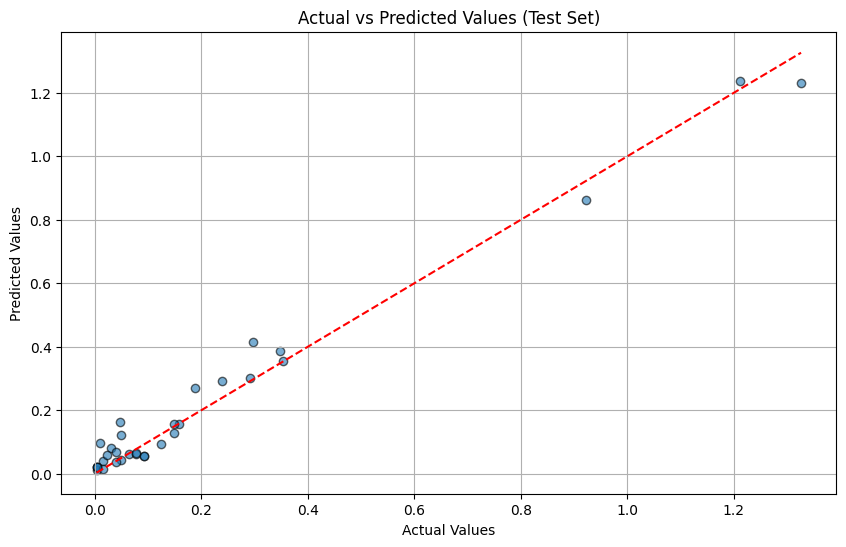

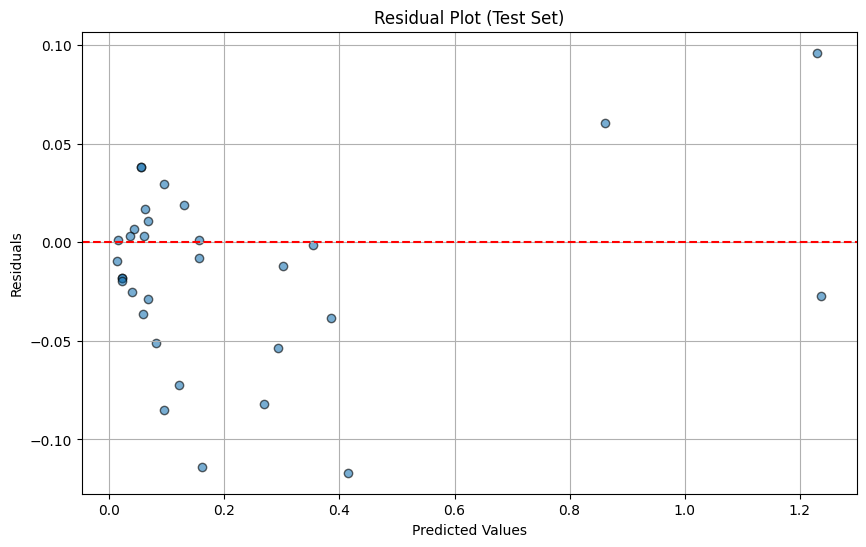

In [4]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import optuna

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

categorical_features = [
    'Production',
    'Raw Material',
    'Raw Material Designation',
    'Surface Treatment'
]

# --- Prepare DataFrame ---
for col in categorical_features:
    df[col] = df[col].astype(str)

selected_features = features_to_scale + categorical_features
X = df[selected_features]

# --- Logarithmic transformation ---
y = df['Total cost with amortization (€/part)']
y_log = np.log1p(y)  # Handle zero values

# --- Optuna Objective Function ---
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
        'verbose': False
    }

    # 5-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train_log, y_val_log = y_log.iloc[train_index], y_log.iloc[val_index]
        y_train = y.iloc[train_index]

        # Feature scaling within fold
        scaler = RobustScaler()
        X_train_scaled = X_train.copy()
        X_val_scaled = X_val.copy()
        X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
        X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])

        # Sample weights
        y_bins = pd.qcut(y_train, q=10, duplicates='drop')
        bin_counts = y_bins.value_counts()
        sample_weights = y_bins.map(lambda b: 1.0 / bin_counts[b])
        sample_weights *= len(y_train) / sample_weights.sum()

        model = CatBoostRegressor(**params)
        model.fit(
            X_train_scaled, y_train_log,
            cat_features=categorical_features,
            sample_weight=sample_weights,
            eval_set=(X_val_scaled, y_val_log),
            use_best_model=True
        )

        # Predict and convert to original scale
        y_pred_log = model.predict(X_val_scaled)
        y_pred = np.expm1(y_pred_log)
        rmse_scores.append(np.sqrt(mean_squared_error(y.iloc[val_index], y_pred)))

    return np.mean(rmse_scores)

# --- Bayesian Optimization with Optuna ---
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Bayesian optimization
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Best Parameters from Optuna ---
best_params = study.best_params
best_params.update({'verbose': 100})
print("\n=== Best Parameters ===")
print(best_params)

# --- Final Training with Best Params ---
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Feature scaling
scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Sample weights
y_bins = pd.qcut(np.expm1(y_train), q=10, duplicates='drop')
bin_counts = y_bins.value_counts()
sample_weights = y_bins.map(lambda b: 1.0 / bin_counts[b])
sample_weights *= len(y_train) / sample_weights.sum()

# Train final model
final_model = CatBoostRegressor(**best_params)
final_model.fit(
    X_train_scaled, y_train,
    cat_features=categorical_features,
    sample_weight=sample_weights,
    eval_set=(X_test_scaled, y_test),
    use_best_model=True
)

# --- Predictions & Evaluation ---
y_pred_log = final_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n=== Final Test Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Test Set)')
plt.grid(True)
plt.show()

residuals = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Set)')
plt.grid(True)
plt.show()
